### Bayesian Data Analysis, 3rd ed
##  Chapter 10, demo 3

Normal approximaton for Bioassay model.

In [1]:
import arviz as az
import numpy as np
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import preliz as pz

import matplotlib.pyplot as plt
pz.style.use('preliz-doc')

In [2]:
# Bioassay data, (BDA3 page 86)
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

In [3]:
# compute the posterior density in grid
#  - usually should be computed in logarithms!
#  - with alternative prior, check that range and spacing of A and B
#    are sensible
ngrid = 100
A = np.linspace(-4, 8, ngrid)
B = np.linspace(-10, 40, ngrid)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

In [4]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50
samp_ld50 = -samp_A / samp_B

Find the mode by minimising negative log posterior. Compute gradients and Hessian analytically, and use Newton's method for optimisation. You may use optimisation routines below for checking your results. See help for scipy.optimize.minimize.

In [5]:
# define the optimised function
def bioassayfun(w):
    a = w[0]
    b = w[1]
    et = np.exp(a + b * x)
    z = et / (1 + et)
    e = - np.sum(y * np.log(z) + (n - y) * np.log(1 - z))
    return e
# initial guess
w0 = np.array([0.0, 0.0])
# optimise
optim_res = minimize(bioassayfun, w0)
# extract desired results
w = optim_res['x']
S = optim_res['hess_inv']

Compute the normal approximation density in grid. Note tha this is just for the illustration and in real case we would not need to evaluate this, and we would only use the draws from the normal distribution approaximation.

In [6]:
# Construct a grid array of shape (ngrid, ngrid, 2) from A and B. Although
# Numpy's concatenation functions do not support broadcasting, a clever trick
# can be applied to overcome this without unnecessary memory copies
# (see Numpy's documentation for strides for more information):
A_broadcasted = np.lib.stride_tricks.as_strided(
    A, shape=(ngrid,ngrid), strides=(0, A.strides[0]))
B_broadcasted = np.lib.stride_tricks.as_strided(
    B, shape=(ngrid,ngrid), strides=(B.strides[0], 0))
grid = np.dstack((A_broadcasted, B_broadcasted))
dist = pz.MvNormal(w, S)
p_norm = dist.pdf(x=grid)

# draw samples from the distribution
samp_norm = dist.rvs(size=1000)

Compute Pareto smoothed importance sampling weights and Pareto diagnostic

In [7]:
lg = np.log(dist.pdf(samp_norm))
Ar = samp_norm[:,0]
Br = samp_norm[:,1]
ilogit_abx = 1 / (np.exp(-(Ar[:,None] + Br[:,None] * x)) + 1)
lp = np.sum(np.log(ilogit_abx**y * (1 - ilogit_abx)**(n - y)), axis=1)
lw = lp - lg
lw, pk = az.stats.psislw(lw)
print("Pareto khat is {:.2}".format(pk))

Pareto khat is 0.66


Importance sampling weights could be used to weight different expectations directly, but for visualisation and easy computation of LD50 histogram, we use resampling importance sampling.

In [8]:
# resampling importance sampling
pis = np.exp(lw)
nsamp = 1000
samp_indices = np.random.choice(pis.size, size=nsamp, p=pis)
rissamp_A = Ar[samp_indices]
rissamp_B = Br[samp_indices]
# add random jitter, see BDA3 p. 76
rissamp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
rissamp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50
rissamp_ld50 = - rissamp_A / rissamp_B

Create figure with all results

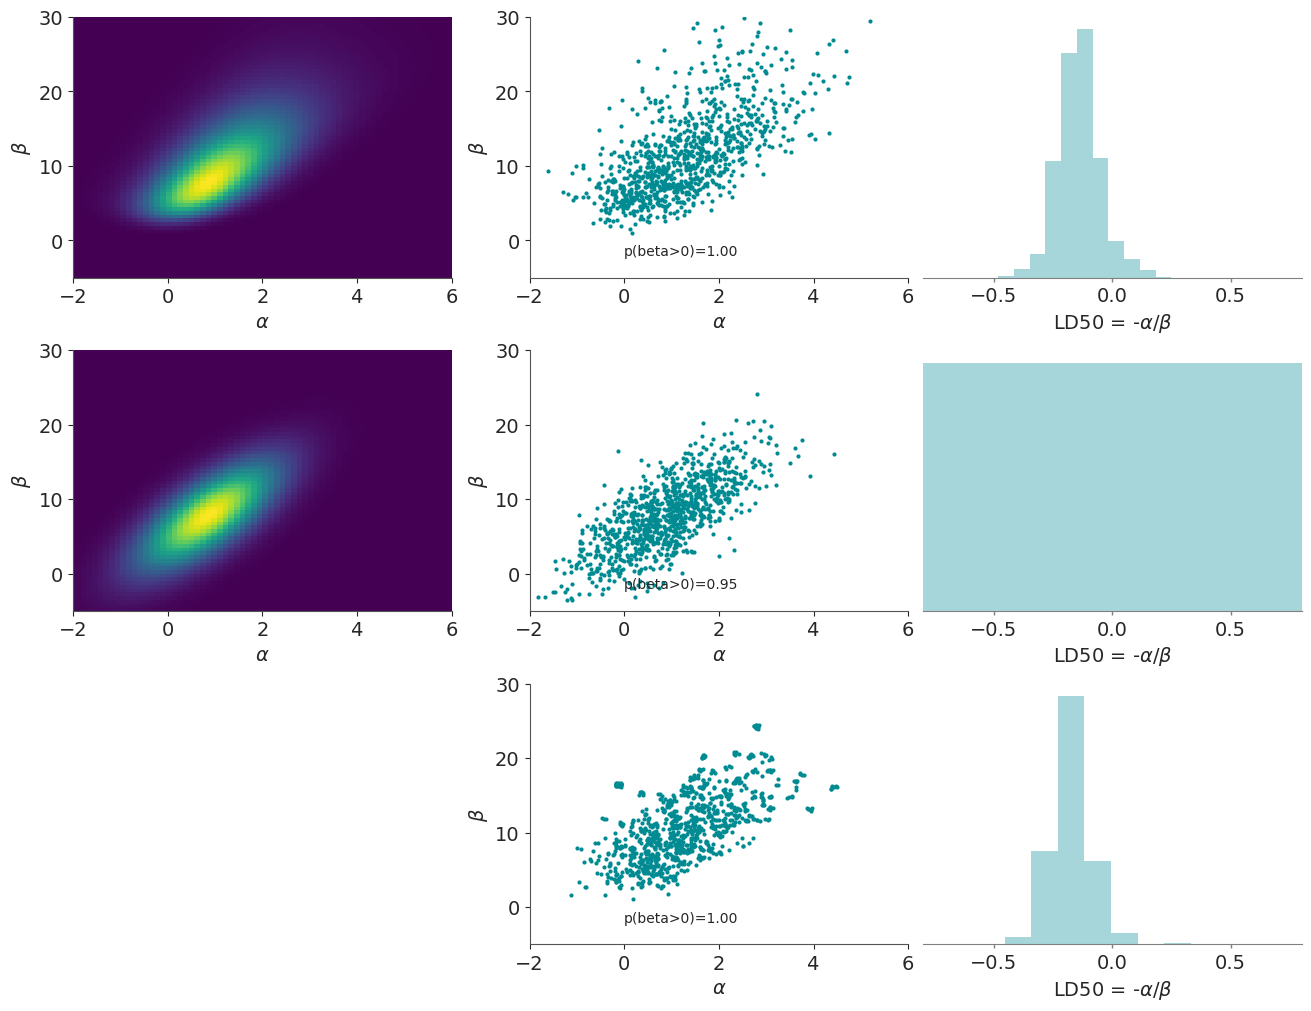

In [9]:
# Convert samples to InferenceData objects
samples = az.from_dict({"A": samp_A, "B": samp_B})
samples_norm = az.from_dict({"A": samp_norm[:, 0], "B": samp_norm[:, 1]})
rissamples = az.from_dict({"A": rissamp_A, "B": rissamp_B})

fig, axes = plt.subplots(3, 3, figsize=(13, 10))
axes = axes.reshape(3, 3)

# Common axis limits and ticks
xlim, ylim = (-2, 6), (-5, 30)
yticks = np.linspace(0, 30, 4)
ld50_xlim, ld50_xticks = (-0.8, 0.8), np.linspace(-0.5, 0.5, 3)

# Row 0: True posterior
axes[0, 0].imshow(p, origin="lower", aspect="auto", extent=(A[0], A[-1], B[0], B[-1]))
axes[0, 0].set(xlim=xlim, ylim=ylim, xlabel=r'$\alpha$', ylabel=r'$\beta$', yticks=yticks)

az.plot_pair(samples, marginals=False, ax=axes[0, 1])
axes[0, 1].set(xlim=xlim, ylim=ylim, xlabel=r'$\alpha$', ylabel=r'$\beta$', yticks=yticks)
axes[0, 1].text(0, -2, f"p(beta>0)={np.mean(samp_B > 0):.2f}")

az.plot_posterior(samp_ld50, kind="hist", point_estimate=None, hdi_prob="hide", ax=axes[0, 2])
axes[0, 2].set(xlim=ld50_xlim, xlabel=r'LD50 = -$\alpha/\beta$', yticks=[], xticks=ld50_xticks, title="")

# Row 1: Normal approximation
axes[1, 0].imshow(p_norm, origin="lower", aspect="auto", extent=(A[0], A[-1], B[0], B[-1]))
axes[1, 0].set(xlim=xlim, ylim=ylim, xlabel=r'$\alpha$', ylabel=r'$\beta$', yticks=yticks)

az.plot_pair(samples_norm, marginals=False, ax=axes[1, 1])
axes[1, 1].set(xlim=xlim, ylim=ylim, xlabel=r'$\alpha$', ylabel=r'$\beta$', yticks=yticks)
axes[1, 1].text(0, -2, f"p(beta>0)={np.mean(samp_norm[:, 1] > 0):.2f}")

bpi = samp_norm[:, 1] > 0
samp_ld50_norm = -samp_norm[bpi, 0] / samp_norm[bpi, 1]
az.plot_posterior(samp_ld50_norm, kind="hist", point_estimate=None, hdi_prob="hide", ax=axes[1, 2])
axes[1, 2].set(xlim=ld50_xlim, xlabel=r'LD50 = -$\alpha/\beta$', yticks=[], xticks=ld50_xticks, title="")

# Row 2: Importance sampling
axes[2, 0].axis("off")

az.plot_pair(rissamples, marginals=False, ax=axes[2, 1])
axes[2, 1].set(xlim=xlim, ylim=ylim, xlabel=r'$\alpha$', ylabel=r'$\beta$', yticks=yticks)
axes[2, 1].text(0, -2, f"p(beta>0)={np.mean(rissamp_B > 0):.2f}")

az.plot_posterior(rissamp_ld50, kind="hist", point_estimate=None, hdi_prob="hide", ax=axes[2, 2])
axes[2, 2].set(xlim=ld50_xlim, xlabel=r'LD50 = -$\alpha/\beta$', yticks=[], xticks=ld50_xticks, title="");


We can see that normal approximation centered at the posterior mode is able to catch some of the posterior shape, but the gives much larger value for $p(\beta>0)$ and longer tails for the marginal posterior of LD50. The importance sampling is able to partially correct the normal approaximation, although it's clearly missing part of the mass in long tail of the true distribution, but still we get much improved approximation for the marginal posterior of LD50.